In [ ]:
# import sys
!apt update && apt install -y libpq-dev libsdl2-dev swig xorg-dev xvfb
%pip install -U tf-agents pyvirtualdisplay
%pip install -U gym>=0.21.0
!git clone https://github.com/openai/mujoco-py.git
%pip install -e ./mujoco-py
%pip install -U gym[all]

In [ ]:
try:
    import pyvirtualdisplay
    display = pyvirtualdisplay.Display(visible=False, size=(1400, 900))
    display.start()
except ImportError:
    pass

In [ ]:
import gym
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from IPython import display as ipythondisplay
import matplotlib as mpl
import matplotlib.animation as animation
mpl.rc('animation', html='jshtml')

np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
env = gym.make("CartPole-v1")
obs = env.reset()
obs

array([ 0.04016603, -0.02694433,  0.00669881, -0.02428384], dtype=float32)

In [ ]:
env.render()

True

In [ ]:
img = env.render(mode="rgb_array")
img.shape

(400, 600, 3)

In [ ]:
def plot_environment(env, figsize=(5,4)):
    plt.figure(figsize=figsize)
    img = env.render(mode="rgb_array")
    plt.imshow(img)
    plt.axis("off")
    return img

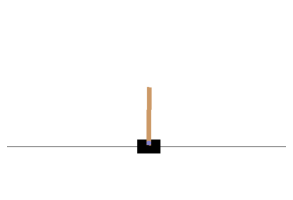

In [ ]:
plot_environment(env)
plt.show()

In [ ]:
env.action_space

Discrete(2)

Since the pole is leaning toward the right (obs[2] > 0), let's accelerate the cart toward the right:

In [ ]:
action = 1  # accelerate right
obs, reward, done, info = env.step(action)
obs

array([-5.2515954e-01,  1.1794072e-05], dtype=float32)

In [ ]:
reward

1.0

Reward during the last step

In [ ]:
done

False

When the game is over, env returns **done=True**

In [ ]:
info

{}

In [ ]:
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

In [ ]:
frames = []

obs = env.reset()
for step in range(300):
    img = env.render(mode="rgb_array")
    frames.append(img)
    action = env.action_space.sample()

    obs, reward, done, info = env.step(action)
plot_animation(frames)

/usr/local/lib/python3.7/dist-packages/gym/envs/classic_control/cartpole.py:151: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  "You are calling 'step()' even though this "


An "episode" is the series of steps that occur between the time the environment is reset and the time it is completed.

In [ ]:
env.seed(42)

def basic_policy(obs):
    angle = obs[2]
    return 0 if angle < 0 else 1

totals = []
for episode in range(500):
    episode_rewards = 0
    obs = env.reset()
    for step in range(200):
        action = basic_policy(obs)
        obs, reward, done, info = env.step(action)
        episode_rewards += reward
        if done:
            break
    totals.append(episode_rewards)

In [ ]:
np.mean(totals), np.std(totals), np.min(totals), np.max(totals)

(41.718, 8.858356280936096, 24.0, 68.0)

In [ ]:
env.seed(42)

frames = []

obs = env.reset()
for step in range(200):
    img = env.render(mode="rgb_array")
    frames.append(img)
    action = basic_policy(obs)

    obs, reward, done, info = env.step(action)
    if done:
        break

In [ ]:
plot_animation(frames)

In [ ]:
#To save animation as gif
anim = plot_animation(frames)
anim.save('/content/drive/MyDrive/randompole.gif', writer='pillow', fps=60)

**Please run the codes below on your local resource**

Make random Actions in MountatinCar Environment

In [ ]:
import gym
env = gym.make('MountainCar-v0')
env.reset()
for _ in range(1000):
    env.render()
    env.step(env.action_space.sample()) # take a random action
env.close()

**Train.py**

In [ ]:
import gym
import sys
import numpy as np
import pickle
import matplotlib.pyplot as plt

env = gym.make('MountainCar-v0')

episodes = 5001

obsSize = [20, 20]
obsWin = (env.observation_space.high - env.observation_space.low) / obsSize
actSize = [env.action_space.n]
low = -2
high = 0
qTable = np.random.uniform(low=low, high=high, size=(obsSize + actSize))

learningRate = 0.2
discount = 0.9
epsilon = 1
epsilonDecayStart = 1
epsilonDecayEnd = episodes // 2
epsilonDecay = epsilon / (epsilonDecayEnd - epsilonDecayStart)


def discretize(rawState) -> tuple:
    state = (rawState - env.observation_space.low) / obsWin
    return tuple(state.astype(int))


def main():
    global epsilon

    reward_list = []
    ave_reward_list = []

    for episode in range(episodes):

        state = discretize(env.reset())

        done = False
        tot_reward, reward = 0, 0
        convergent = False

        while not done:
            if np.random.random() > epsilon:
                action = np.argmax(qTable[state])
            else:
                action = np.random.randint(0, env.action_space.n)

            rawNewState, reward, done, _ = env.step(action)
            newState = discretize(rawNewState)

            if not done:
                maxFutureQ = np.max(qTable[newState])
                currentQ = qTable[state + (action,)]
                q = (1 - learningRate) * currentQ + learningRate * (reward + discount * maxFutureQ)
                qTable[state + (action,)] = q

            elif rawNewState[0] >= env.goal_position:
                qTable[state + (action,)] = 0
                convergent = True
                print(f'Made it in {episode} episode')

            state = newState
            tot_reward += reward

            if episode % 500 == 0:
                # print(f'{episode}')
                env.render()
        if episode % 500 == 0:
            print(f'{episode}')


        if epsilonDecayEnd >= episode >= epsilonDecayStart:
            epsilon -= epsilonDecay

        reward_list.append(tot_reward)
        if (episode+1) % 100 == 0:
            ave_reward = np.mean(reward_list)
            ave_reward_list.append(ave_reward)
            reward_list = []

        env.close()

        if episode == 5000:
            with open(f'{episode}.pkl', 'wb') as f:
                pickle.dump(qTable, f)
            break
            env.close()

    plt.plot(100*(np.arange(len(ave_reward_list)) + 1), ave_reward_list)
    plt.xlabel('Episodes')
    plt.ylabel('Average Reward')
    plt.title('Average Reward vs Episodes')
    plt.savefig('rewards.jpg')
    plt.close()

main()

**Test.py**

In [ ]:
import pickle

import gym
import numpy as np

qTablePkl = f'5000.pkl'
qTable = pickle.load(open(qTablePkl, 'rb'))
qTable: np.ndarray

env = gym.make('MountainCar-v0')
obsSize = [20, 20]
obsWin = (env.observation_space.high - env.observation_space.low) / obsSize
actSize = [env.action_space.n]


def discretize(rawState) -> tuple:
    state = (rawState - env.observation_space.low) / obsWin
    return tuple(state.astype(int))


def main():
    n = 10 # change to your desired number of episodes
    i = 0
    while i<n:
        state = discretize(env.reset())
        done = False
        while not done:
            action = np.argmax(qTable[state])
            rawNewState, reward, done, _ = env.step(action)
            state = discretize(rawNewState)
            isOpen = env.render()
            if not isOpen:
                print(f'Closed!')
                return
            if rawNewState[0] >= env.goal_position:
                print(f'trial {i+1}: Done!')
                i=i+1
                if i==n:
                    done = True
                    env.close()
                    print(f'Test Ended!')

main()

**GymTest.py** this is for you to play game! You are the agent :)

In [ ]:
#!/usr/bin/env python
import gym
import sys
import time

env = gym.make('MountainCar-v0')

if not hasattr(env.action_space, 'n'):
    raise Exception('Keyboard agent only supports discrete action spaces')
ACTIONS = env.action_space.n
SKIP_CONTROL = 0  # Use previous control decision SKIP_CONTROL times, that's how you
# can test what skip is still usable.

human_agent_action = 1
human_wants_restart = False
human_sets_pause = False


def key_press(key, mod):
    global human_agent_action, human_wants_restart, human_sets_pause
    if key == 0xff0d: human_wants_restart = True
    if key == 32: human_sets_pause = not human_sets_pause
    a = int(key - ord('0'))
    if a <= 0 or a >= ACTIONS: return
    human_agent_action = a


def key_release(key, mod):
    global human_agent_action
    a = int(key - ord('0'))
    if a <= 0 or a >= ACTIONS: return
    if human_agent_action == a:
        human_agent_action = 1


env.reset()
env.render()
env.unwrapped.viewer.window.on_key_press = key_press
env.unwrapped.viewer.window.on_key_release = key_release


def rollout(env):
    global human_agent_action, human_wants_restart, human_sets_pause
    human_wants_restart = False
    obser = env.reset()
    skip = 0
    total_reward = 0
    total_timesteps = 0
    while 1:
        if not skip:
            # print("taking action {}".format(human_agent_action))
            a = human_agent_action
            total_timesteps += 1
            skip = SKIP_CONTROL
        else:
            skip -= 1

        obser, r, done, info = env.step(a)
        if r != 0:
            pass
            # print("reward %0.3f" % r)
        total_reward += r
        window_still_open = env.render()
        if window_still_open == False: return False
        if done: break
        if human_wants_restart: break
        while human_sets_pause:
            env.render()
            time.sleep(0.1)
        time.sleep(0.1)
    print("timesteps %i reward %0.2f" % (total_timesteps, total_reward))


print("ACTIONS={}".format(ACTIONS))
print("Press keys 1 2 3 ... to take actions 1 2 3 ...")
print("No keys pressed is taking action 0")

while 1:
    window_still_open = rollout(env)
    if window_still_open == False: break
